Mediapipe contains a set of pre-trained models for various tasks, including face detection, hand tracking, and pose estimation. These models are designed to work efficiently on mobile devices and can be used in real-time applications.
in this notebook, we will explore how to use mediapipe for face detection and hand tracking. We will also discuss how to visualize the results using OpenCV.

**Note:** we are using the latest version of mediapipe (0.10.1) that means we have to import the model to create a task instead of using the old interface that involves using the `mediapipe.solutions` module. The new interface is more flexible and allows for easier integration with other libraries and frameworks.
# Import necessary libraries

In [10]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

import os

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

Model for hand landmarker providing by google:

https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker/index#models

The hand landmark model bundle detects the keypoint localization of 21 hand-knuckle coordinates within the detected hand regions.

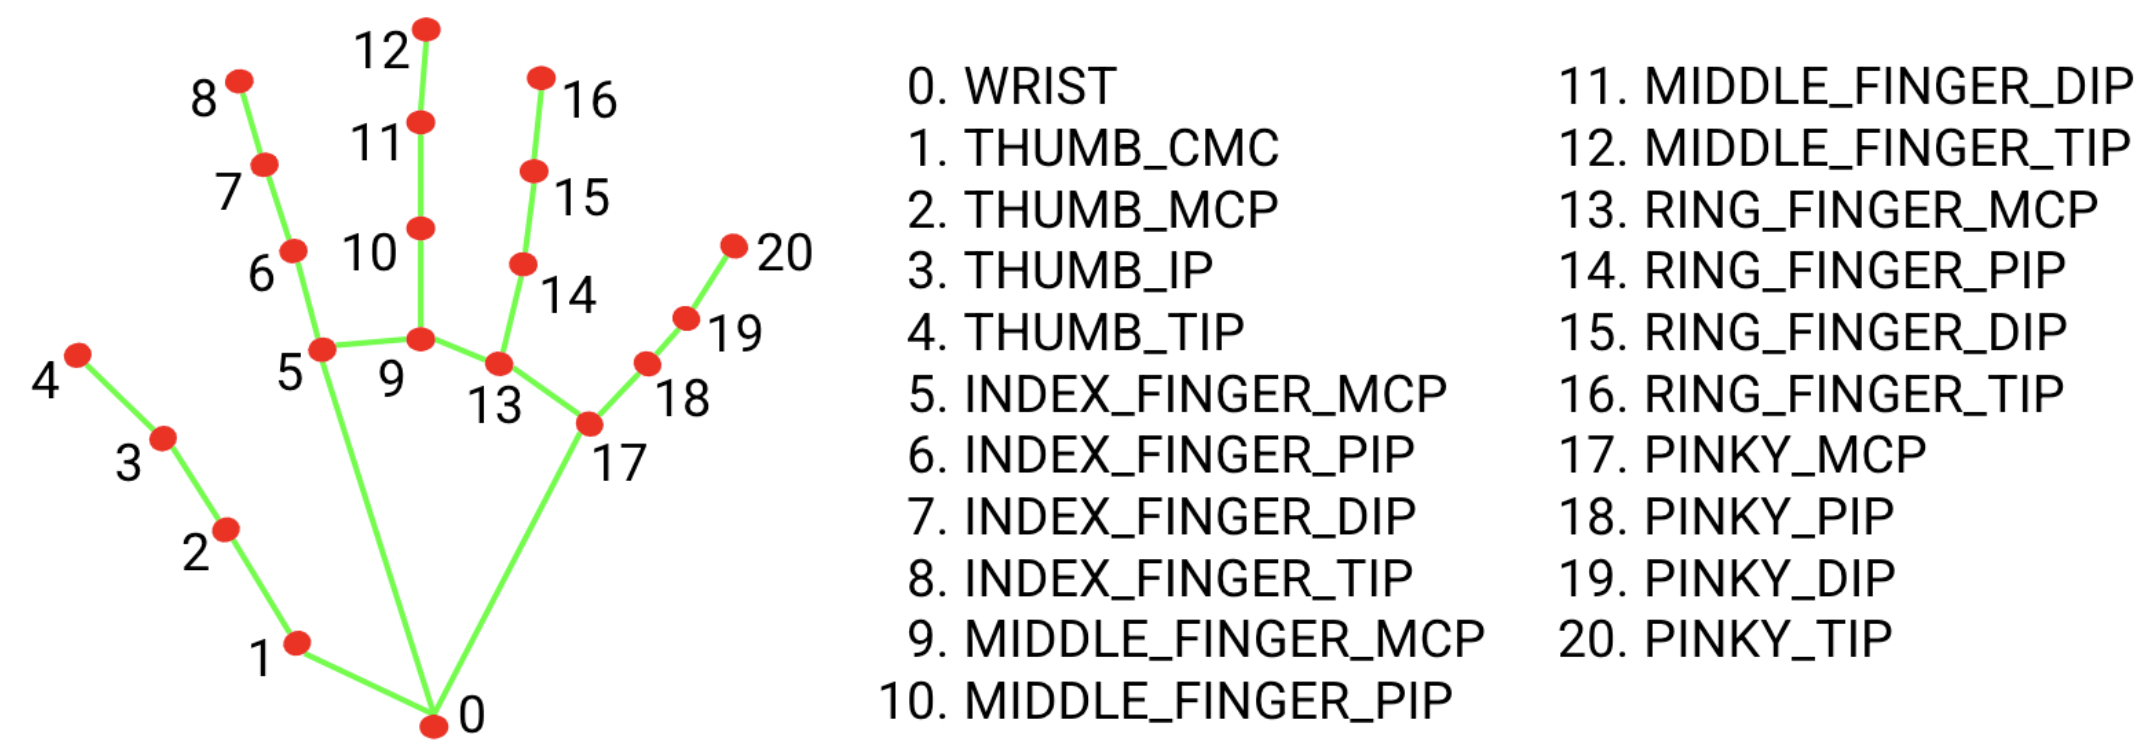

In [11]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

model_path = os.path.join(base_path, "models", "hand_landmarker.task")
image_path = os.path.join(base_path, "data", "images", "image-003.png")

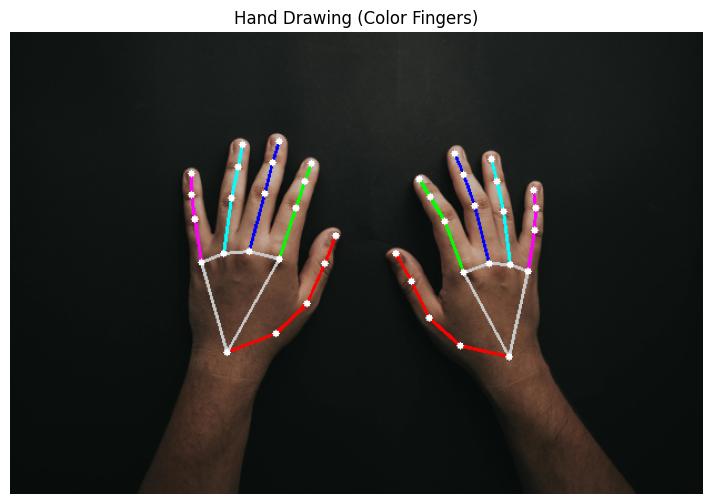

In [12]:
# Setup classes
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# MediaPipe landmark connections (same as old API)
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),       # Index
    (5, 9), (9,10), (10,11), (11,12),     # Middle
    (9,13), (13,14), (14,15), (15,16),    # Ring
    (13,17), (17,18), (18,19), (19,20),   # Pinky
    (0,17)                                # Palm base
]

# Define finger colors
FINGER_COLORS = {
    "thumb": (0, 0, 255),     # Red
    "index": (0, 255, 0),     # Green
    "middle": (255, 0, 0),    # Blue
    "ring": (255, 255, 0),    # Yellow
    "pinky": (255, 0, 255),   # Magenta
    "palm": (200, 200, 200)   # Light gray
}

# Define MediaPipe-style connections per finger
FINGER_CONNECTIONS = {
    "thumb": [(0, 1), (1, 2), (2, 3), (3, 4)],
    "index": [(5, 6), (6, 7), (7, 8)],
    "middle": [(9,10), (10,11), (11,12)],
    "ring": [(13,14), (14,15), (15,16)],
    "pinky": [(17,18), (18,19), (19,20)],
    "palm": [(0, 5), (0, 17), (5, 9), (9, 13), (13, 17)]  # grey palm base shape
}

# Create and run landmarker
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    num_hands=2
)

# Read image as BGR (OpenCV default)
bgr = cv2.imread(image_path)
# Convert to RGB for MediaPipe model
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

with HandLandmarker.create_from_options(options) as landmarker:
    result = landmarker.detect(mp_image)

    # Draw results still keep using bgr for drawing
    # because OpenCV drawing functions expect BGR

    if result.hand_landmarks:
        for hand in result.hand_landmarks:
            h, w = bgr.shape[:2]

            # Draw connections
            for finger, connections in FINGER_CONNECTIONS.items():
                color = FINGER_COLORS[finger]
                for start_idx, end_idx in connections:
                    x1 = int(hand[start_idx].x * w)
                    y1 = int(hand[start_idx].y * h)
                    x2 = int(hand[end_idx].x * w)
                    y2 = int(hand[end_idx].y * h)
                    cv2.line(bgr, (x1, y1), (x2, y2), color, 2)

            # Draw landmark points
            for lm in hand:
                x = int(lm.x * w)
                y = int(lm.y * h)
                cv2.circle(bgr, (x, y), 3, (255, 255, 255), -1)  # white dots

    else:
        print("❌ No hands detected.")

# Convert BGR (OpenCV) to RGB for Matplotlib
image_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Display inline
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Hand Drawing (Color Fingers)")
plt.show()

